### Project Imports

In [2]:
import os.path
import numpy as np
import torch

import minimal_version.parser_handler

from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

### Project Configuration
Configure your project using the configuration file. Use the modelConfig template as a guide. 

A value of -1 indicates that the default value will be used. 

Please note that every time the RunSetup class is executed, the current version of the configuration file will be copied to your specified directory, allowing you to review all set parameters at any time.  

Run just one of the two cell below (working with/without Pfam)

In [ ]:
CONFIGURATION_FILE = "msaExample.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

In [ ]:
CONFIGURATION_FILE = "pfamExample.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = True

### MSA preprocessing
Prepare your MSA for training by filtering it according to the queries specified in the configuration file. This includes both the query sequences and any fixed sequences defined.

In [ ]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()


#### Conditional labels
Before starting the training process, ensure that your labels are properly preprocessed if you intend to use them for **conditional training**. 

This involves converting your labels into a suitable format, such as one-hot or integer encoding (see and modify **custom_classifier** function). 

Additionally, specify the number of classes represented by your labels.

In [3]:
# Specify number of classes
N_CLASSES = 3

def parse_conditional_labels_to_categories(file_name):
    """ Parse conditional label file """
    # Please specify your classification function to the bins, the interface of function must stay the same, example
    def custom_classifier(sol_val: float) -> torch.Tensor:
        if sol_val < run.solubility_threshold1:
            return torch.tensor([1,0,0])
        if sol_val <= run.solubility_threshold2:
            return torch.tensor([0,1,0])
        return torch.tensor([0,0,1])
    
    label_dict = {}
    with open(file_name, "r") as sol_data:
        for i, record in enumerate(sol_data):
            if i == 0:  # header
                continue
            accession, label_val = record.split("\t")
            if label_val is None or len(label_val) == '':
                print(f"Error while parsing labels, accession {accession} does not have labels")
                exit(1)
            label_dict[accession] = custom_classifier(float(label_val))
    return label_dict

""" In the case of conditional model please preprocess labels """
label_file_path = run.conditional_labels  # you can specify it in the configuration path or provide custom one 

# Now get labels from your file, simple txt or similar file with sequence accession\tlabel_value pair per line (modify function as needed)  
label_dict = parse_conditional_labels_to_categories(label_file_path)

labels_file_pkl = os.path.join(run.conditional_data, "conditional_labels_to_categories.pkl")
msa_keys = load_from_pkl(os.path.join(run.pickles, "keys_list.pkl"))

# get labels to the similar order as in msa (just in case, to enable using indexes in training method)
msa_key_label_order = {}
array_of_labels = torch.zeros(len(msa_keys), N_CLASSES)
for label_i, msa_key in enumerate(msa_keys):
    try:
        msa_key_label_order[msa_key] = label_dict[msa_key]
        array_of_labels[label_i] = label_dict[msa_key]
    except KeyError:
        print(f"{msa_key} is not in the label_dict, please provide labels for all sequences")
        exit(1)
        
# now store in both raw and text version
store_to_pkl(array_of_labels, labels_file_pkl)
with open(os.path.join(run.conditional_data, "msa_key_label_order.txt"), 'w') as txt_labels:
    for k, label_tensor in msa_key_label_order.items():
        txt_labels.write(f"{k} {label_tensor}\n")

### Training of the model
Select the models you would like to work with and prepare data for training and benchmarking if selected in configuration file. 

If you select a conditional model please see above cell and prepare labels for it.  

In [5]:
""" Configure model """
available_models = ["vae", "vae_conditional"]
model_selected = available_models[0]

""" Prepare data for training """
setup_train(run, model_selected)

 Leaving out 5% sequences from training for generative capacity evaluation (812 sequences in total)


In [ ]:
"""
Train VAE with a preprocessed MSA
:param conf_path: path to the configuration file of the project
:return:
"""
# logging
train_log = open(os.path.join(run.logs, 'train_log.txt'), "w")
model = Train(run)
with Capturing() as output_train:
    model.train()
train_log.write(" Training \n" + "\n".join(output_train) + f'\n{"=" * 80}\n')
train_log.close()

In [ ]:
""" Do I work with conditional model? """

load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

### Generative Capacity evaluation
If you wish to obtain estimates of your model's generative capacity, please set run_capacity_test to true in the configuration file before starting the training.

This test generates first and second order statistics of your model.

In [ ]:
from notebooks.minimal_version.benchmark import Benchmarker
""" 
Benchmark model 
How well our model can regenarate sequences in various sets (positive, negative and training)
"""
N_SAMPLES = 500

Benchmarker(run, samples=N_SAMPLES).bench_dataset()

### Projection to the latent space
Project all points to the latent space and make custom selection of sequences

Configuration file stored in ../results/debug_cond/config/2024-08-15_09-49.json
 Working with modelConfigConditional.json configuration file!


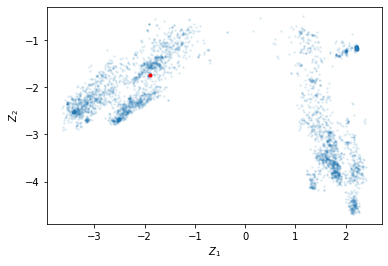

In [2]:
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace

# Projection to the latent space
# Show your queries 
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

query_coords = latent_space.key_to_embedding(run.query)

custom_sequences = []  # give keys to MSA and embed them to the latent space


fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
ax.plot(query_coords[0], query_coords[1], '.', color='red')

# Project 
for seq_id, seq_mu in enumerate(custom_sequences):
    ax.plot(seq_mu[0], seq_mu[1], '.', color='black', alpha=1, markersize=5,
            label='({})'.format(seq_id))
    
    ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
fig_lat.savefig(os.path.join(run.results, "latent_space.png"))

### Generate ancestors
Using straight evolution protocol  

In [ ]:
from notebooks.minimal_version.evolution_protocols.straight_evolution import StraightEvolution

protocol = StraightEvolution(run)
ancestors = protocol.get_ancestors(profile=False)

### Project the conditional labels on the latent space

In [ ]:
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace

assert load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model'] == "vae_conditional"

labels_file_pkl = os.path.join(run.conditional_data, "conditional_labels_to_categories.pkl")
msa_idx_to_label = load_from_pkl(labels_file_pkl)
# Projection to the latent space
# Show your queries 
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

query_coords = latent_space.key_to_embedding(run.query)

custom_sequences = []  # give keys to MSA and embed them to the latent space

fig_lat, ax = plt.subplots(1, 1)

colors_map = ['r', 'b', 'g']
label_values = [label.argmax() for label in msa_idx_to_label]

# Convert one-hot tensors to tuples for mapping to colors
colors = [colors_map[one_hot] for one_hot in label_values]

ax.scatter(msa_embeddings[:, 0], msa_embeddings[:, 1], c=colors, alpha=0.1)
ax.plot(query_coords[0], query_coords[1], '.', color='red')

# Project 
for seq_id, seq_mu in enumerate(custom_sequences):
    ax.plot(seq_mu[0], seq_mu[1], '.', color='black', alpha=1, markersize=5,
            label='({})'.format(seq_id))
    
    ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
fig_lat.savefig(os.path.join(run.results, "conditional_latent_space.png"), dpi=500)